In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from UsefulFunctions import *
import seaborn as sns
from config_path import MS_DATA_PATH
print(MS_DATA_PATH)

Base path: ..
../data/ms


In [2]:


df = pd.read_csv(f'{MS_DATA_PATH}/220316_ghost_nrt_filtered.tsv', sep='\t')
design_matrix = pd.read_csv(f'{MS_DATA_PATH}/design_matrix_group_de_early_time_points_subtypes.tsv', sep='\t')

GroupOneCols = design_matrix[design_matrix['Group'] == 1]['Sample'].values
GroupTwoCols = design_matrix[design_matrix['Group'] == 2]['Sample'].values

print(len(GroupOneCols))
print(len(GroupTwoCols))

30
42


### Peptide distribution in samples

In [3]:
nr_unique_proteins = len(df['Protein'].unique())
print(f'# unique proteins: {nr_unique_proteins} ')

df['PeptideCount1'] = df[GroupOneCols].count(axis=1)
df['PeptideCount2'] = df[GroupTwoCols].count(axis=1)
df['PeptideCountSum'] = df['PeptideCount1']+df['PeptideCount2']
df['IntensitySum1'] = df[GroupOneCols].sum(axis=1)
df['IntensitySum2'] = df[GroupTwoCols].sum(axis=1)
df['IntensityMean1'] = df[GroupOneCols].mean(axis=1)
df['IntensityMean2'] = df[GroupTwoCols].mean(axis=1)
df['FC'] = df['IntensityMean1'] / df['IntensityMean2']
df['IntensitySum'] = df['IntensitySum1'] + df['IntensitySum2']

# unique proteins: 1039 


Sum1:  107377
Sum2:  154532


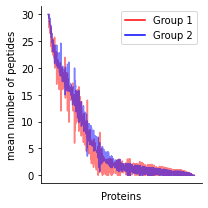

In [25]:
# Histogram of peptides per protein
protein_peptide_count = df.groupby('Protein', as_index=False).mean()[['Protein','PeptideCount1','PeptideCount2','PeptideCountSum']]

groupratio = len(GroupOneCols)/len(GroupTwoCols)
protein_peptide_count = protein_peptide_count.sort_values('PeptideCountSum',ascending=False)
df1 = protein_peptide_count[['Protein','PeptideCount1']]
df2 = protein_peptide_count[['Protein', 'PeptideCount2']]
df1 = df1.rename(columns={'PeptideCount1':'PeptideCount'})
df2 = df2.rename(columns={'PeptideCount2':'PeptideCount'})
df1['Group'] = 'Group 1'
df2['Group'] = 'Group 2'
df2['PeptideCount'] = df2['PeptideCount'] * groupratio
df1['i'] = range(len(df1.index))
df2['i'] = range(len(df2.index))
df_new = pd.concat([df1,df2])
fig = plt.figure(figsize=(3,3))
df_new.reset_index(inplace=True)
fig, ax = plt.subplots(2,1,sharex=True, figsize = (4,4), gridspec_kw={'height_ratios': [2, 1]})
sns.lineplot(data=df_new, x = 'Protein', y = 'PeptideCount', hue='Group', palette=['red','blue'], alpha=0.5)
print('Sum1: ', df['PeptideCount1'].sum())
print('Sum2: ', df['PeptideCount2'].sum())
plt.xticks([])
#plt.xscale('log')
plt.xlabel('Proteins')
plt.ylabel('mean number of peptides')
plt.legend()
sns.despine(top=True, right=True, left=False, bottom=False)

plt.tight_layout()
#plt.savefig('../plots/general/PeptideCount.jpg', dpi=300)

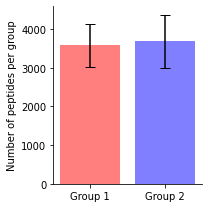

In [25]:

group1_peptides = []
for col in GroupOneCols:
    group1_peptides.append(df[col].count())
group1_mean =  np.mean(group1_peptides)
group1_sd = np.std(group1_peptides)
group2_peptides = []
for col in GroupTwoCols:
    group2_peptides.append(df[col].count())
group2_mean = np.mean(group2_peptides)
group2_sd = np.std(group2_peptides)
fig = plt.figure(figsize=(3,3))
plt.bar(x = ['Group 1', 'Group 2'], height = [group1_mean,group2_mean], 
        yerr=[group1_sd, group2_sd], 
        capsize=5, 
        color=['red', 'blue'], 
        alpha=0.5,)
plt.ylabel('Number of peptides per group')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()
plt.savefig('../plots/general/PeptidesPerGroupBar.jpg', dpi=300)

/tmp/ipykernel_7351/1368713628.py:10: RuntimeWarning: divide by zero encountered in log10
  df_new['logI'] = [np.log10(x) for x in df_new['IntensitySum']]


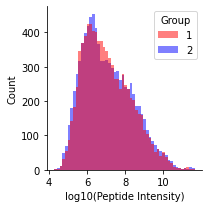

In [61]:
df1 = df[['PeptideSequence','IntensitySum1']]
df2 = df[['PeptideSequence', 'IntensitySum2']]
df1 = df1.rename(columns={'IntensitySum1':'IntensitySum'})
df2 = df2.rename(columns={'IntensitySum2':'IntensitySum'})
df1['Group'] = 'Group 1'
df2['Group'] = 'Group 2'

df_new = pd.concat([df1,df2])
df_new.reset_index(inplace=True)
df_new['logI'] = [np.log10(x) for x in df_new['IntensitySum']]
fig,ax  = plt.subplots(figsize=(3,3))
sns.histplot(data=df_new, kde=False, x= 'logI', hue='Group', edgecolor=None, palette=['red','blue'], alpha=0.5, ax=ax)
plt.xlabel('log10(Peptide Intensity)')
sns.despine()
plt.tight_layout()
plt.savefig('../plots/general/PeptideIntensityHistogram.jpg', dpi=300)

### Protein level

## DPKS
---

In [26]:
from dpks.quant_matrix import QuantMatrix

quant_matrix = QuantMatrix(
    quantification_file=f"{MS_DATA_PATH}/220316_ghost_nrt_filtered.tsv",
    design_matrix_file=f"{MS_DATA_PATH}/design_matrix_group_de_early_time_points_subtypes.tsv"
)

compare_df = (
        quant_matrix
        .filter() # filter for q-values (removes rows with low q value (peptides), Q = 0.01) and removes decoys
        .normalize(method="mean", use_rt_sliding_window_filter = True) # best type of normalization is RT-sliding window
        .quantify(method="maxlfq") # play around with minimum_subgroups (default is set 1)
    ).compare_groups(
        method='linregress',
        group_a=1,
        group_b=2,
        min_samples_per_group = 2, 
        level='protein',
    ).to_df()
compare_df

/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/dpks/normalization.py:116: RuntimeWarning: Mean of empty slice
  sample_means = np.nanmean(X, axis=0)


,Protein,Group1Mean,Group2Mean,Log2FoldChange1-2,PValues1-2,Group1RepCounts,Group2RepCounts,CorrectedPValue,TM_M2012_010,TM_M2012_011,...,TM_M2012_177,TM_M2012_178,TM_M2012_182,TM_M2012_183,TM_M2012_186,TM_M2012_188,TM_M2012_189,TM_M2012_196,TM_M2012_197,TM_M2012_198
0,P06396,21.288717,21.226708,0.062010,0.694861,30,42,0.721447,21.690603,20.691873,...,20.419413,21.028937,21.542064,21.509333,21.198022,21.245511,21.200419,23.029393,23.389134,23.470304
1,P10643,21.516173,21.613422,-0.097249,0.503560,30,42,0.625305,21.677649,21.190349,...,21.893203,21.188014,21.371173,21.436145,21.356409,21.040272,21.362647,21.331875,21.524378,21.930228
2,P03952,20.936229,20.612498,0.323731,0.045767,30,42,0.149304,21.023477,20.770036,...,20.505599,20.608387,20.970957,20.752389,21.042518,20.957229,21.163873,22.332772,22.704704,22.773377
3,P02750,23.510573,23.954318,-0.443745,0.003362,30,42,0.023420,22.807610,23.269826,...,23.784981,24.566548,24.806581,24.787613,22.859750,22.901881,23.686287,24.103840,23.764547,24.052968
4,Q04756,19.586920,18.838137,0.748783,0.000072,30,41,0.001191,19.657972,19.115191,...,18.220235,18.721893,18.931209,18.973254,19.296811,18.608288,19.034313,20.708523,20.283616,20.454671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,P01275,NaN,NaN,NaN,NaN,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1035,P16104,NaN,NaN,NaN,NaN,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.966682
1036,O00194,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1037,Q6R327,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/tmp/ipykernel_1586/1900047276.py:17: RuntimeWarning: divide by zero encountered in log10
  df_new['logI'] = [np.log10(x) for x in df_new['IntensitySum']]


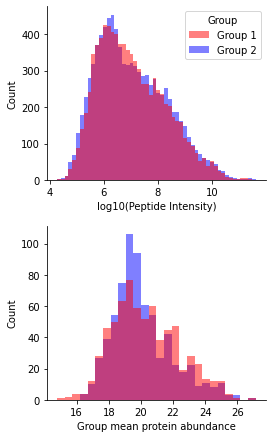

In [55]:
prot_df1 = compare_df[['Protein','Group1Mean']]
prot_df2 = compare_df[['Protein', 'Group2Mean']]
prot_df1 = prot_df1.rename(columns={'Group1Mean':'GroupMean'})
prot_df2 = prot_df2.rename(columns={'Group2Mean':'GroupMean'})
prot_df1['Group'] = 'Group 1'
prot_df2['Group'] = 'Group 2'

df1 = df[['PeptideSequence','IntensitySum1']]
df2 = df[['PeptideSequence', 'IntensitySum2']]
df1 = df1.rename(columns={'IntensitySum1':'IntensitySum'})
df2 = df2.rename(columns={'IntensitySum2':'IntensitySum'})
df1['Group'] = 'Group 1'
df2['Group'] = 'Group 2'

df_new = pd.concat([df1,df2])
df_new.reset_index(inplace=True)
df_new['logI'] = [np.log10(x) for x in df_new['IntensitySum']]
fig, ax = plt.subplots(2,1,figsize = (4,6), gridspec_kw={'height_ratios': [1, 1]})

sns.histplot(data=df_new, kde=False, x= 'logI', hue='Group', edgecolor=None, palette=['red','blue'], alpha=0.5, ax=ax[0])
ax[0].set_xlabel('log10(Peptide Intensity)')
sns.despine()
plt.tight_layout()

prot_df_new = pd.concat([prot_df1,prot_df2])
prot_df_new.reset_index(inplace=True)
sns.histplot(data=prot_df_new, kde=False, x= 'GroupMean', hue='Group', edgecolor=None, legend=False, palette=['red','blue'], alpha=0.5, ax=ax[1])
ax[1].set_xlabel('Group mean protein abundance')

plt.savefig('../plots/general/PepProtHist.jpg', dpi=300, bbox_inches='tight')

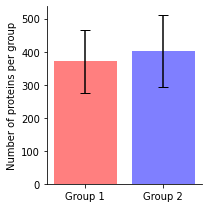

In [60]:
#Proteins per group
group1_proteins = []
for col in GroupOneCols:
    group1_proteins.append(compare_df[col].count())
group1_mean =  np.mean(group1_proteins)
group1_sd = np.std(group1_proteins)
group2_proteins = []
for col in GroupTwoCols:
    group2_proteins.append(compare_df[col].count())
group2_mean = np.mean(group2_proteins)
group2_sd = np.std(group2_proteins)
fig = plt.figure(figsize=(3,3))
plt.bar(x = ['Group 1', 'Group 2'], height = [group1_mean,group2_mean], 
        yerr=[group1_sd, group2_sd], 
        capsize=5, 
        color=['red', 'blue'], 
        alpha=0.5,)
plt.ylabel('Number of proteins per group')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()
plt.savefig('../plots/general/ProteinsPerGroupBar.jpg', dpi=300)

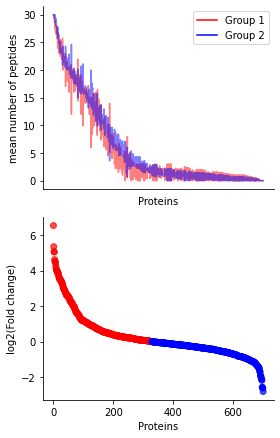

In [56]:
compare_df = compare_df.sort_values('Log2FoldChange1-2', ascending=False)
protein_peptide_count = df.groupby('Protein', as_index=False).mean()[['Protein','PeptideCount1','PeptideCount2','PeptideCountSum']]
compare_df_no_NaN = compare_df.dropna(subset=['Log2FoldChange1-2'])
#print(compare_df_no_NaN[:5].Protein, compare_df_no_NaN[:5]['Log2FoldChange1-2'])
#print(compare_df_no_NaN[len(compare_df_no_NaN.index)-5:len(compare_df_no_NaN.index)].Protein, 
     # compare_df_no_NaN[len(compare_df_no_NaN.index)-5:len(compare_df_no_NaN.index)]['Log2FoldChange1-2'])
def pltcolor(vals):
    cols=[]
    for y in vals:
        if y > 0:
            cols.append('red')
        else:
            cols.append('blue')
    return cols
colors = pltcolor(compare_df['Log2FoldChange1-2'].values)



groupratio = len(GroupOneCols)/len(GroupTwoCols)
protein_peptide_count = protein_peptide_count.sort_values('PeptideCountSum',ascending=False)
df1 = protein_peptide_count[['Protein','PeptideCount1']]
df2 = protein_peptide_count[['Protein', 'PeptideCount2']]
df1 = df1.rename(columns={'PeptideCount1':'PeptideCount'})
df2 = df2.rename(columns={'PeptideCount2':'PeptideCount'})
df1['Group'] = 'Group 1'
df2['Group'] = 'Group 2'
df2['PeptideCount'] = df2['PeptideCount'] * groupratio
df1['i'] = range(len(df1.index))
df2['i'] = range(len(df2.index))
df_new = pd.concat([df1,df2])
df_new.reset_index(inplace=True)



fig, ax = plt.subplots(2,1,figsize = (4,6), gridspec_kw={'height_ratios': [1, 1]})


sns.lineplot(data=df_new, x = 'Protein', y = 'PeptideCount', hue='Group', palette=['red','blue'], alpha=0.5, ax=ax[0])

ax[0].set_xticks([])
#plt.xscale('log')
ax[0].set_xlabel('Proteins')
ax[0].set_ylabel('mean number of peptides')
ax[0].legend()
sns.despine(top=True, right=True, left=False, bottom=False)


g = ax[1].scatter(x=range(len(compare_df.index)),y=compare_df['Log2FoldChange1-2'], alpha=0.7,color=colors)
sns.despine()
ax[1].set_ylabel('log2(Fold change)')
plt.tight_layout()
ax[1].set_xlabel('Proteins')
plt.savefig('../plots/general/PeptideDistFC.jpg', bbox_inches='tight', dpi=300)


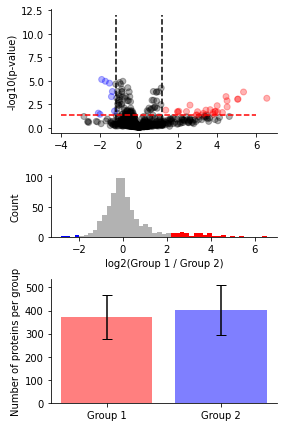

In [57]:
compare_df['logPValue'] = -1.0 * np.log10(compare_df['CorrectedPValue'])
compare_df['color'] = compare_df.apply(lambda x: color_if_significant(x), axis=1)

fig, ax = plt.subplots(3,1,sharex=False, figsize = (4,6), gridspec_kw={'height_ratios': [2, 1, 2]})

group1_proteins = []
for col in GroupOneCols:
    group1_proteins.append(compare_df[col].count())
group1_mean =  np.mean(group1_proteins)
group1_sd = np.std(group1_proteins)
group2_proteins = []
for col in GroupTwoCols:
    group2_proteins.append(compare_df[col].count())
group2_mean = np.mean(group2_proteins)
group2_sd = np.std(group2_proteins)


ax[0].scatter(x=compare_df['Log2FoldChange1-2'].values , y=compare_df['logPValue'].values, color=compare_df['color'].values, alpha=0.3)

ax[0].vlines(1.2, ymin=0, ymax=12, color='k', linestyle='dashed')
ax[0].vlines(-1.2, ymin=0, ymax=12,color='k', linestyle='dashed')
ax[0].hlines(1.31, xmin=-4, xmax=6, color='red', linestyle='dashed')
ax[0].set_ylabel('-log10(p-value)')

g = sns.histplot(compare_df['Log2FoldChange1-2'].values, color='black',alpha=0.3, linewidth=0, ax = ax[1])
for p in range(len(g.patches)):
    x,_ = g.patches[p].xy
    if x < -2:
        g.patches[p].set_facecolor('blue')
    elif x > 2:
        g.patches[p].set_facecolor('red')

ax[1].set_ylabel('Count')
ax[1].set_xlabel('log2(Group 1 / Group 2)')

ax[2].bar(x = ['Group 1', 'Group 2'], height = [group1_mean,group2_mean], 
        yerr=[group1_sd, group2_sd], 
        capsize=5, 
        color=['red', 'blue'], 
        alpha=0.5,)
ax[2].set_ylabel('Number of proteins per group')

plt.tight_layout()
sns.despine(ax=ax[0])
sns.despine(ax=ax[1])
sns.despine(ax=ax[2])

plt.savefig('../plots/general/ProteinVolcanoHist.jpg', bbox_inches='tight', dpi=300)

In [44]:
quant_matrix = QuantMatrix(
    quantification_file=f"{MS_DATA_PATH}/220316_ghost_nrt_filtered.tsv",
    design_matrix_file=f"{MS_DATA_PATH}/design_matrix_group_de_early_time_points_subtypes.tsv"
)

precursor_compare_df = (quant_matrix.filter().normalize(method="mean", use_rt_sliding_window_filter = True)).compare_groups(
        method='linregress',
        group_a=1,
        group_b=2,
        min_samples_per_group = 2, 
        level='precursor',
    ).to_df()

/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/dpks/normalization.py:116: RuntimeWarning: Mean of empty slice
  sample_means = np.nanmean(X, axis=0)


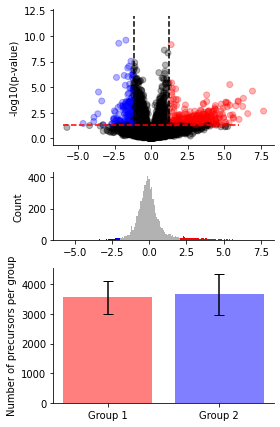

In [58]:
precursor_compare_df['logPValue'] = -1.0 * np.log10(precursor_compare_df['PValues1-2'])
precursor_compare_df['color'] = precursor_compare_df.apply(lambda x: color_if_significant(x), axis=1)

group1_precursor = []
for col in GroupOneCols:
    group1_precursor.append(precursor_compare_df[col].count())
group1_mean =  np.mean(group1_precursor)
group1_sd = np.std(group1_precursor)
group2_precursor = []
for col in GroupTwoCols:
    group2_precursor.append(precursor_compare_df[col].count())
group2_mean = np.mean(group2_precursor)
group2_sd = np.std(group2_precursor)

fig, ax = plt.subplots(3,1, figsize = (4,6), gridspec_kw={'height_ratios': [2, 1, 2]})
ax[0].scatter(x=precursor_compare_df['Log2FoldChange1-2'].values , y=precursor_compare_df['logPValue'].values, color=precursor_compare_df['color'].values, alpha=0.3)

ax[0].vlines(1.2, ymin=0, ymax=12, color='k', linestyle='dashed')
ax[0].vlines(-1.2, ymin=0, ymax=12,color='k', linestyle='dashed')
ax[0].hlines(1.31, xmin=-6, xmax=6, color='red', linestyle='dashed')
ax[0].set_ylabel('-log10(p-value)')

g = sns.histplot(precursor_compare_df['Log2FoldChange1-2'].values, color='black',alpha=0.3, linewidth=0, ax = ax[1])
for p in range(len(g.patches)):
    x,_ = g.patches[p].xy
    if x < -2:
        g.patches[p].set_facecolor('blue')
    elif x > 2:
        g.patches[p].set_facecolor('red')

ax[1].set_ylabel('Count')

ax[2].bar(x = ['Group 1', 'Group 2'], height = [group1_mean,group2_mean], 
        yerr=[group1_sd, group2_sd], 
        capsize=5, 
        color=['red', 'blue'], 
        alpha=0.5,)
ax[2].set_ylabel('Number of precursors per group')

plt.tight_layout()
sns.despine(ax=ax[0])
sns.despine(ax=ax[1])
sns.despine(ax=ax[2])
plt.savefig('../plots/general/PrecursorVolcanoHist.jpg', bbox_inches='tight', dpi=300)